In [1]:
from Neuron_analysis_tool.Analyzer import Analyzer, long_pulse_protocol
from neuron import gui, h
import numpy as np
import os
import matplotlib.pyplot as plt

NEURON: unable to open font "*helvetica-medium-r-normal*--14*", using "fixed"


## Loading rall model

In [2]:
analyser = Analyzer(type='L5PC')

## plot the cell morphology

optimizing lines: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 111863.33it/s]


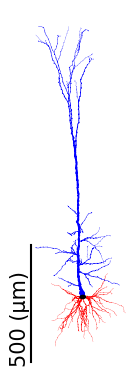

In [3]:
_,_,_ = analyser.plot_morph(scale=500, diam_factor=0.5, theta=-90, ignore_soma=True)

## create a somaticentric view card 

optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 36118.08it/s]


(<Figure size 1200x300 with 4 Axes>,
 array([<AxesSubplot:title={'center':'morphology'}>,
        <AxesSubplot:title={'center':'d3_2 dendogram'}>,
        <AxesSubplot:title={'center':'long pulse attanuation'}, xlabel='distance from origin (x / λ)', ylabel='V(x)/V(0)'>,
        <AxesSubplot:title={'center':'short pulse attanuation'}, xlabel='distance from origin (x / λ)'>],
       dtype=object))

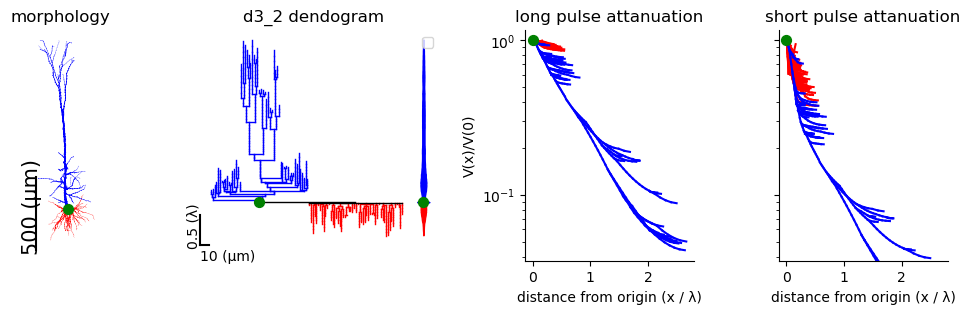

In [4]:
analyser.create_card(theta=-90, diam_factor=0.5)

## create a spasific segment centric view card

optimizing lines: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 106611.80it/s]


(<Figure size 1200x300 with 4 Axes>,
 array([<AxesSubplot:title={'center':'morphology'}>,
        <AxesSubplot:title={'center':'d3_2 dendogram'}>,
        <AxesSubplot:title={'center':'long pulse attanuation'}, xlabel='distance from origin (x / λ)', ylabel='V(x)/V(0)'>,
        <AxesSubplot:title={'center':'short pulse attanuation'}, xlabel='distance from origin (x / λ)'>],
       dtype=object))

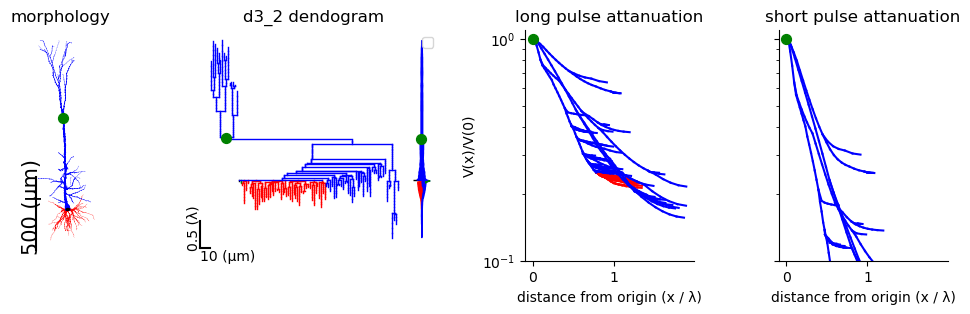

In [5]:
analyser.create_card(start_seg=list(analyser.cell.apic[50])[-1], theta=-90, diam_factor=0.5)

## defining a new protocol to record, protocol is a function that gets the cell and the start segment (in the case you intrested of using a spasific one), and runs a simulation.
### the function muyst return the tstop of the simulation, the delay/time to start, the duration of the activation, the amplitude, and a dictionary with extra stuff you want to save for to the end of the computation of this video

In [3]:
def Ca_spike_protocol(cell, start_seg):
    delay=400.0
    stim = h.IClamp(0.5, sec=cell.soma[0])
    stim.dur   = 5
    stim.delay = delay

    syn = h.epsp(cell.apic[36](0.9))
    syn.tau0  = 0.5
    syn.tau1 = 5
    syn.onset   = stim.delay + 5
    syn.imax = 0.5 
    stim.amp = 1.9
    
    h.tstop = 700
    h.v_init = cell.soma[0].e_pas
    h.celsius = 37
    h.run()
    return 400, {}

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


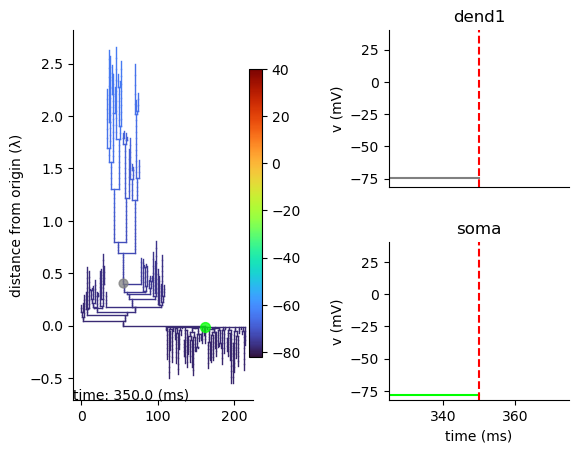

In [4]:
show_records_from = dict()
show_records_from[list(analyser.cell.soma[0])[0]] = dict(label='soma', alpha=0.75, color='lime', size=50)
show_records_from[list(analyser.cell.apic[36])[0]] = dict(label='dend1', alpha=0.75, color='grey', size=40)

record_dict, _ = analyser.record_protocol(protocol=Ca_spike_protocol, cut_start_ms=None, record_name='v')
animation = analyser.create_movie_from_rec(records=record_dict, slow_down_factor=50, 
                                           func_for_missing_frames=np.max, theta=-90, diam_factor=None, 
                                           show_records_from=show_records_from, seg_to_indicate_dict=dict(),
                                           base_plot_type='dendogram')
animation.ipython_display(fps=10, loop=True, autoplay=True)

optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 29989.92it/s]


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


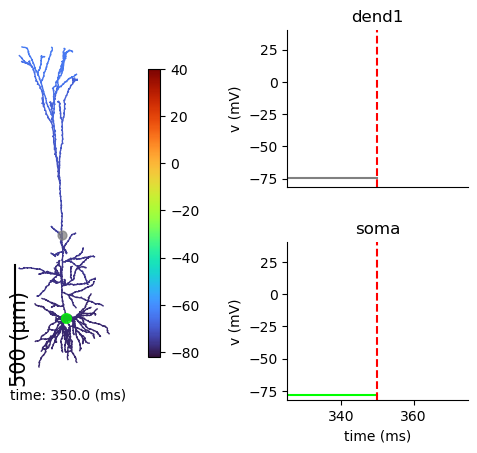

In [9]:
show_records_from = dict()
show_records_from[list(analyser.cell.soma[0])[0]] = dict(label='soma', alpha=0.75, color='lime', size=50)
show_records_from[list(analyser.cell.apic[36])[0]] = dict(label='dend1', alpha=0.75, color='grey', size=40)

record_dict, _ = analyser.record_protocol(protocol=Ca_spike_protocol, cut_start_ms=None, record_name='v')
animation = analyser.create_movie_from_rec(records=record_dict, slow_down_factor=50, 
                                           func_for_missing_frames=np.max, theta=-90, diam_factor=None, 
                                           show_records_from=show_records_from, seg_to_indicate_dict=dict(),
                                           base_plot_type='morph')
animation.ipython_display(fps=10, loop=True, autoplay=True)

### you can also create a movie af spasific channel conductance

In [10]:
# get all the mechanisem name in the model
analyser.get_mechanism_names()

['Ca_LVAst',
 'SK_E2',
 'NaTa_t',
 'Im',
 'K_Pst',
 'Nap_Et2',
 'Ca_HVA',
 'K_Tst',
 'ca_ion',
 'pas',
 'Ih',
 'CaDynamics_E2',
 'na_ion',
 'SKv3_1',
 'k_ion']

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


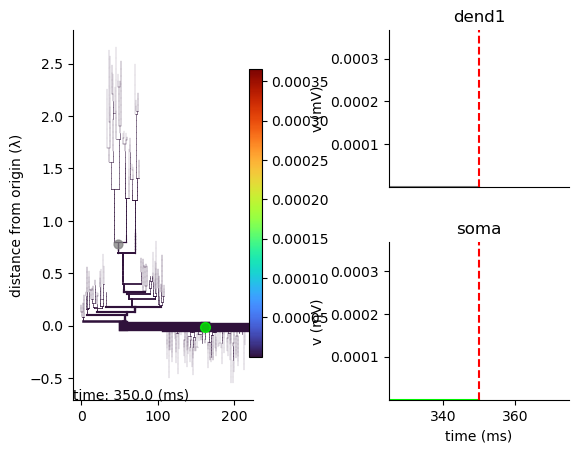

In [11]:
show_records_from = dict()
show_records_from[list(analyser.cell.soma[0])[0]] = dict(label='soma', alpha=0.75, color='lime', size=50)
show_records_from[list(analyser.cell.apic[50])[-1]] = dict(label='dend1', alpha=0.75, color='grey', size=40)
record_dict, _ = analyser.record_protocol(protocol=Ca_spike_protocol, cut_start_ms=None, record_name='gCa_LVAst_Ca_LVAst')
animation = analyser.create_movie_from_rec(records=record_dict, slow_down_factor=50, 
                                           func_for_missing_frames=np.max, theta=-90, diam_factor=0.5, 
                                           show_records_from=show_records_from, seg_to_indicate_dict=dict(),
                                          base_plot_type='dendogram')
animation.ipython_display(fps=10, loop=True, autoplay=True)

# animation.write_videofile(os.path.join('data', 'L5PC_Ca_gCa_LVAst_Ca_LVAst' + '.mp4'),
#                               fps=10, threads=4,
#                               audio=False, preset='ultrafast')